In [1]:
import numpy
import scipy.stats
import scipy.special
import py_monte_carlo
from matplotlib import pyplot
import pickle
import os
import random

In [36]:
side_len = 6
nvars = side_len*side_len

x = numpy.arange(side_len)
y = x
X, Y = numpy.meshgrid(x, y)

INDX = Y*side_len + X
RIGHT = Y*side_len + (X+1)%side_len
BOT = (((Y+1) % side_len )*side_len + X)

right_edges = [((a, b), -1.0) for a, b in zip(INDX.flatten(), RIGHT.flatten())]
bot_edges = [((a, b), -1.0 if b%2 else 1.0) for a, b in zip(INDX.flatten(), BOT.flatten())]

edges =  right_edges + bot_edges
edge_list = numpy.asarray([(a, b) for ((a, b),_) in edges])
edge_values = numpy.asarray([j for _, j in edges])

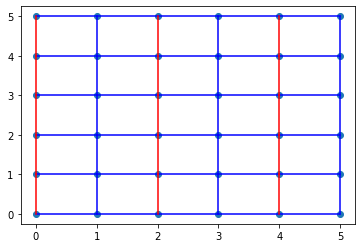

In [3]:
pyplot.scatter(X.flatten(), Y.flatten())
for (a,b),j in edges:
    c = 'b'
    if j > 0:
        c = 'r'
    ax = a % side_len
    ay = a // side_len
    bx = b % side_len
    by = b // side_len
    if abs(bx - ax) <= 1 and abs(by - ay) <= 1: 
        pyplot.plot([ax, bx], [ay, by], c)
    else:
        pass
        #pyplot.plot(xs, ys, c+'--')

In [4]:
def parallel(a, b):
    ax, ay = a
    bx, by = b
    dx = bx - ax
    dy = by - ay
    ny = (by + dy) % side_len
    nx = (bx + dx) % side_len
    return (bx, by), (nx, ny)

def plot_state(state):
    state = numpy.asarray(state)
    edge_gen = ((state[a] ^ state[b],j) for (a,b), j in edges)
    dimer_states = [a if j<0 else not a for a,j in edge_gen]
    all_indices = numpy.asarray([(a,b) for (a,b),_ in edges])
    x_all_indices = all_indices % side_len
    y_all_indices = all_indices // side_len
    all_coords = numpy.dstack([x_all_indices, y_all_indices])
    dimer_lookup = dict(((tuple(a), tuple(b)), s) for (a,b), s in zip(all_coords, dimer_states))
    
    xs = X.flatten()
    ys = Y.flatten()
    inds = INDX.flatten()
    
    if state.any():
        pyplot.scatter(xs[state[inds]], ys[state[inds]], marker='x', c='r')
    if not state.all():
        pyplot.scatter(xs[numpy.logical_not(state[inds])], ys[numpy.logical_not(state[inds])], marker='x', c='b')
    
    for k,v in dimer_lookup.items():
        c = 'b'
        if v:
            c = 'r'
        a, b = k
        xs, ys = zip(a, b)
        
        xs = list(xs)
        ys = list(ys)
        if abs(xs[0] - xs[1]) > 1:
            xs[0] = max(xs[0], xs[1])
            xs[1] = xs[0] + 1
        if abs(ys[0] - ys[1]) > 1: 
            ys[0] = min(ys[0], ys[1]) - 1
            ys[1] = ys[0] + 1
        
        avg_x = sum(xs)/2.0
        avg_y = sum(ys)/2.0

        if xs[0] == xs[1]:
            pyplot.plot([avg_x-0.5, avg_x+0.5], [avg_y,avg_y], c)
        else:
            pyplot.plot([avg_x, avg_x], [avg_y-0.5,avg_y+0.5], c)
        
    pyplot.show()
    
    tot = 0
    count = 0
    for k in filter(lambda k: dimer_lookup[k], dimer_lookup):
        tot += 1
        if dimer_lookup[parallel(*k)]:
            count += 1
    return (tot, count)

Create an initial columnar state

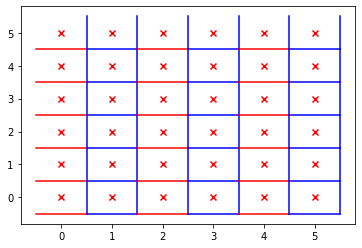

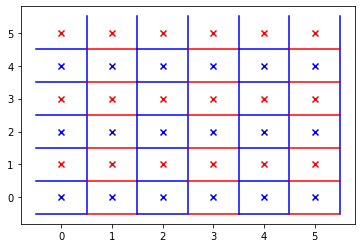

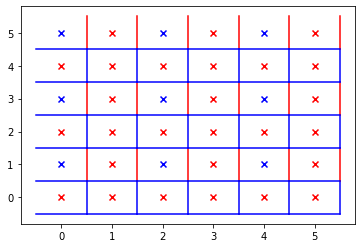

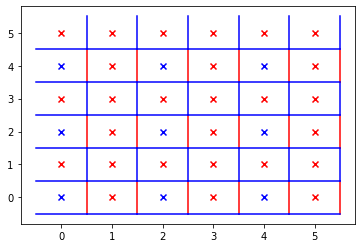

In [5]:
def foo(i, b):
    if bool(i // 6 % 2) == b:
        return bool(i % 2)
    else:
        return True
columnar_a = [True for _ in range(nvars)]
columnar_b = [True if (i // 6) % 2 else False for i in range(nvars)]
columnar_c = [True if foo(i, True) else False for i in range(nvars)]
columnar_d = [True if foo(i, False) else False for i in range(nvars)]

for c in [columnar_a, columnar_b, columnar_c, columnar_d]:
    plot_state(c)

In [6]:
def get_linearish(data, window=20):
    lowest_err = (0,0,1e512, 0)
    i = 0
    while i < len(data)-window:
        subdat = data[i:i+window]
        if any(numpy.isnan(subdat)):
            i += window
        else:
            slope, intercept, _, _, std_err = scipy.stats.linregress(range(i, i+window), subdat)
            if std_err < lowest_err[2]:
                lowest_err = (slope, intercept, std_err, i)
            i += 1
    return lowest_err

In [7]:
hs = 10**numpy.linspace(-1, 1, 30)
hs = numpy.concatenate([hs, [1]])
hs = numpy.sort(hs)

betas = 10**numpy.linspace(-1, 1, 30)
betas = numpy.concatenate([betas, [1]])
betas = numpy.sort(betas)

HS, BETAS = numpy.meshgrid(hs, betas)

In [8]:
if not os.path.exists('corrs'):
    os.mkdir('corrs')
    
def load_or_run_corr(h, beta, timesteps=1000):
    filename = 'corrs/{}'.format(hash((h, beta)))
    bond_correlation = None
    if os.path.exists(filename):
        try:
            with open(filename, 'rb') as f:
                bond_correlation = pickle.load(f)
        except:
            bond_correlation = None
    if bond_correlation is None:
        graph = py_monte_carlo.Lattice(edges)
        graph.set_initial_state(columnar_a)
        graph.set_transverse_field(h)
        bond_correlation = numpy.mean(numpy.asarray(graph.run_quantum_monte_carlo_and_measure_bond_autocorrelation(beta, timesteps, 16)), axis=0)
        with open(filename, 'wb') as w:
            pickle.dump(bond_correlation, w)
    return bond_correlation

@numpy.vectorize
def run_corrs(h, beta, offset=5):
    bond_correlation = load_or_run_corr(h, beta)
    return bond_correlation[offset]/bond_correlation[0]


@numpy.vectorize
def run_corrs_linearish(h, beta, head=100, window=20):
    bond_correlation = load_or_run_corr(h, beta)
    slope, _, _, _ = get_linearish(numpy.log(bond_correlation[:head]), window=window)
    return float(slope)

In [9]:
correlations = run_corrs(HS, BETAS, offset=1)

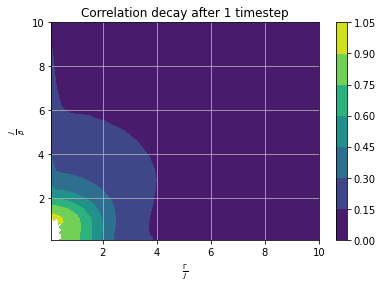

In [10]:
pyplot.contourf(HS, 1/BETAS, correlations)
pyplot.xlabel(r'$\frac{\Gamma}{J}$')
pyplot.ylabel(r'$\frac{J}{\beta}$')
pyplot.title(r'Correlation decay after 1 timestep')
pyplot.colorbar()
pyplot.grid()
pyplot.show()

In [11]:
correlations_linearization = run_corrs_linearish(HS, BETAS, head=20, window=10)

/home/sumner/.virtualenvs/dwave/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


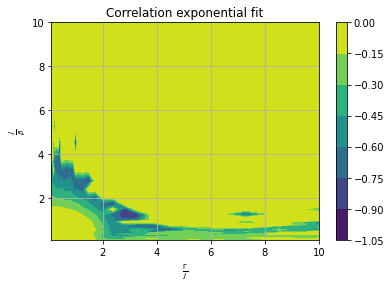

In [12]:
pyplot.contourf(HS, 1/BETAS, correlations_linearization)
pyplot.xlabel(r'$\frac{\Gamma}{J}$')
pyplot.ylabel(r'$\frac{J}{\beta}$')
pyplot.title(r'Correlation exponential fit')
pyplot.colorbar()
pyplot.grid()
pyplot.show()

/home/sumner/.virtualenvs/dwave/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/sumner/.virtualenvs/dwave/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/sumner/.virtualenvs/dwave/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/home/sumner/.virtualenvs/dwave/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


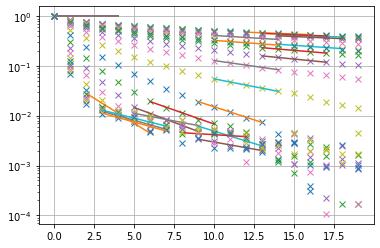

In [13]:
beta = betas[-1]
window = 5
for h in hs:
    cs = load_or_run_corr(h, beta)
    slope, intercept, _, i = get_linearish(numpy.log(cs[:20]), window=window)
    pyplot.plot(cs[:20], 'x', label='{}'.format(h))
    xs = numpy.arange(i,i+window)
    pyplot.plot(xs, numpy.exp(slope*xs + intercept))

pyplot.grid()
pyplot.yscale('log')
pyplot.show()

In [146]:
def make_bond_matrix(var_mat):
    var_mat = numpy.asarray(var_mat)
    a_values = var_mat[edge_list[:, 0], :]
    b_values = var_mat[edge_list[:, 1], :]

    # Gives +1 if variables are equal, -1 if not
    spin_product = a_values * b_values
    # Gives +1 if edge is positive, -1 if not.
    edge_signs = numpy.expand_dims(numpy.sign(edge_values), -1)

    # If edge is positive, and product is negative (unequal), then satisfied.
    # So satisfied edges are negative, broken are positive
    old_shape = spin_product.shape
    new_spin_product = spin_product.reshape((old_shape[0], -1))
    dimer_prod = new_spin_product * edge_signs
    return dimer_prod.reshape(old_shape)

In [178]:
if not os.path.exists('samples'):
    os.mkdir('samples')
    
def load_or_run_samples(h, beta, timesteps, num_experiments=16):
    filename = 'samples/{}'.format(hash((h, beta, timesteps, num_experiments)))
    samples = None
    if os.path.exists(filename):
        try:
            with open(filename, 'rb') as f:
                _, _, _, _, samples = pickle.load(f)
        except:
            samples = None
    if samples is None:
        graph = py_monte_carlo.Lattice(edges)
        graph.set_initial_state(columnar_a)
        graph.set_transverse_field(h)
        samples = graph.run_quantum_monte_carlo_sampling(beta, timesteps, num_experiments)
        with open(filename, 'wb') as w:
            pickle.dump((h, beta, timesteps, num_experiments, samples), w)
    return samples

columnar_a_default_dimers = make_bond_matrix(numpy.asarray([columnar_a]).T * 2 - 1)


def dot_samples(h, beta, default_dimers=None, timesteps=1000, start_index=0, end_index=-1):
    if default_dimers is None:
        default_dimers = columnar_a_default_dimers
    samples = load_or_run_samples(h, beta, timesteps=timesteps)
    samples, _ = zip(*samples)
    samples = numpy.asarray(samples)[:,start_index:end_index,:].T
    samples = samples * 2 - 1
    bond_mat = make_bond_matrix(samples)
    bond_mat = bond_mat.reshape((bond_mat.shape[0], -1))
    
    # Using only 1, -1 the magnitude is shape[0] for each
    dots = bond_mat.T @ default_dimers / (default_dimers.shape[0] * bond_mat.shape[0] )
    return numpy.mean(dots)
dot_samples = numpy.vectorize(dot_samples, excluded=['default_dimers'])


def kl_samples(h, beta, default_dimers=None, timesteps=1000, start_index=0, end_index=-1):
    if default_dimers is None:
        default_dimers = columnar_a_default_dimers
    samples = load_or_run_samples(h, beta, timesteps=timesteps)
    samples, _ = zip(*samples)
    samples = numpy.asarray(samples)[:,start_index:end_index,:].T
    samples = samples * 2 - 1
    bond_mat = make_bond_matrix(samples)
    bond_mat = bond_mat.reshape((bond_mat.shape[0], -1))
    average_bonds = (1 + numpy.mean(bond_mat, axis=-1))/2
    # Get KL Divergence
    p_sample = average_bonds.flatten()
    p_exact = (default_dimers.flatten()+1)/2
    return numpy.sum(scipy.special.rel_entr(p_exact, p_sample))
kl_samples = numpy.vectorize(kl_samples, excluded=['default_dimers'])
    

def self_entropy_samples(h, beta, default_dimers=None, timesteps=1000, start_index=0, end_index=-1):
    if default_dimers is None:
        default_dimers = columnar_a_default_dimers
    samples = load_or_run_samples(h, beta, timesteps=timesteps)
    samples, _ = zip(*samples)
    samples = numpy.asarray(samples)[:,start_index:end_index,:].T
    samples = samples * 2 - 1
    bond_mat = make_bond_matrix(samples)
    bond_mat = bond_mat.reshape((bond_mat.shape[0], -1))
    average_bonds = (1 + numpy.mean(bond_mat, axis=-1))/2
    p_sample = average_bonds.flatten()
    return numpy.sum(scipy.stats.entropy(p_sample))
self_entropy_samples = numpy.vectorize(self_entropy_samples, excluded=['default_dimers'])

In [179]:
columnar_a_default_dimers = make_bond_matrix(numpy.asarray([columnar_a]).T * 2 - 1)
columnar_b_default_dimers = make_bond_matrix(numpy.asarray([columnar_b]).T * 2 - 1)
columnar_c_default_dimers = make_bond_matrix(numpy.asarray([columnar_c]).T * 2 - 1)
columnar_d_default_dimers = make_bond_matrix(numpy.asarray([columnar_d]).T * 2 - 1)

dots_a = dot_samples(HS, BETAS, default_dimers=columnar_a_default_dimers)
dots_b = dot_samples(HS, BETAS, default_dimers=columnar_b_default_dimers)
dots_c = dot_samples(HS, BETAS, default_dimers=columnar_c_default_dimers)
dots_d = dot_samples(HS, BETAS, default_dimers=columnar_d_default_dimers)

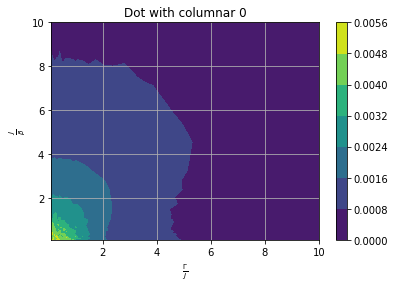

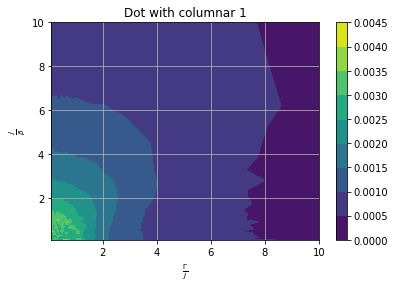

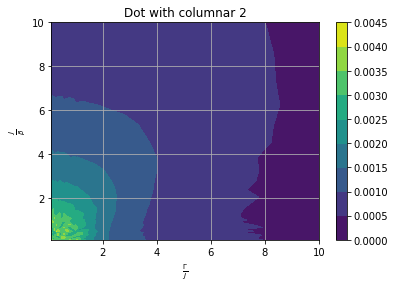

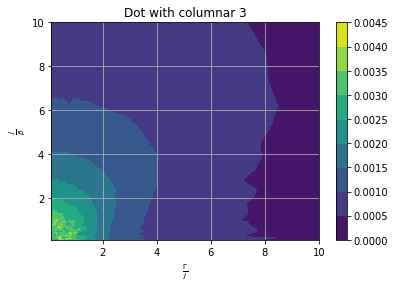

In [180]:
for i, dots in enumerate([dots_a, dots_b, dots_c, dots_d]):
    pyplot.contourf(HS, 1/BETAS, dots)
    pyplot.xlabel(r'$\frac{\Gamma}{J}$')
    pyplot.ylabel(r'$\frac{J}{\beta}$')
    pyplot.title(r'Dot with columnar {}'.format(i))
    pyplot.colorbar()
    pyplot.grid()
    pyplot.show()

In [181]:
kl_divs = kl_samples(HS, BETAS)

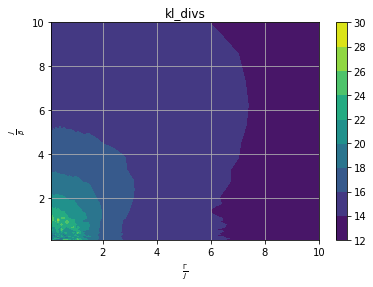

In [182]:
pyplot.contourf(HS, 1/BETAS, kl_divs)
pyplot.xlabel(r'$\frac{\Gamma}{J}$')
pyplot.ylabel(r'$\frac{J}{\beta}$')
pyplot.title(r'kl_divs')
pyplot.colorbar()
pyplot.grid()
pyplot.show()

In [183]:
self_entropies = self_entropy_samples(HS, BETAS)

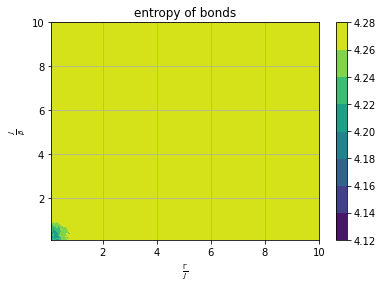

In [184]:
pyplot.contourf(HS, 1/BETAS, self_entropies)
pyplot.xlabel(r'$\frac{\Gamma}{J}$')
pyplot.ylabel(r'$\frac{J}{\beta}$')
pyplot.title(r'entropy of bonds')
pyplot.colorbar()
pyplot.grid()
pyplot.show()

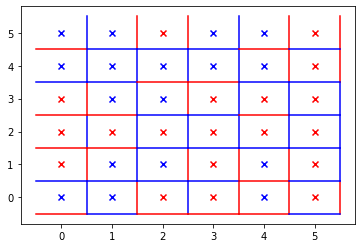

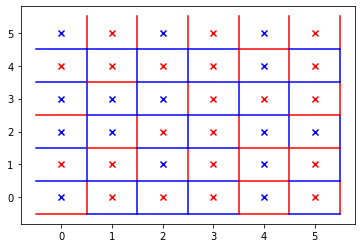

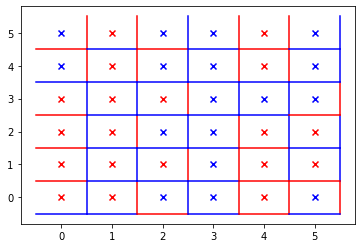

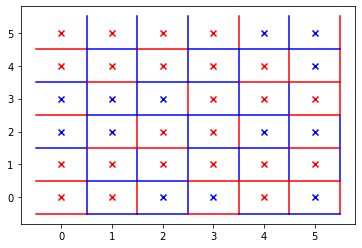

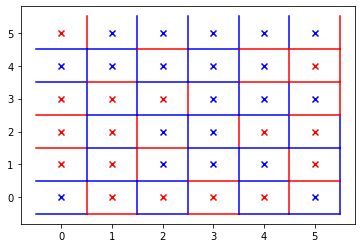

In [185]:
samples = load_or_run_samples(hs[0], betas[-1], timesteps=1000)
samples, energies = zip(*samples)
bond_mat = make_bond_matrix(numpy.asarray(samples).T)
bond_mat = bond_mat.reshape((bond_mat.shape[0], -1))
average_bonds = (1 + numpy.mean(bond_mat, axis=-1))/2
average_bonds

for i in range(0, 5):
    plot_state(samples[0][i])

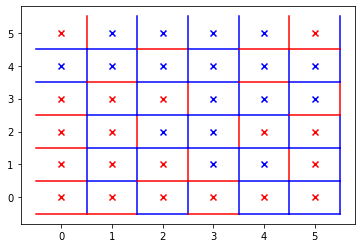

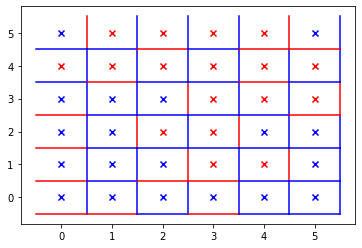

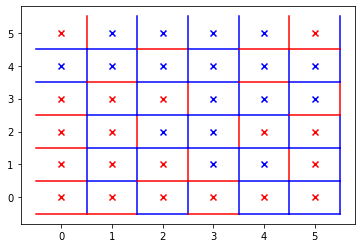

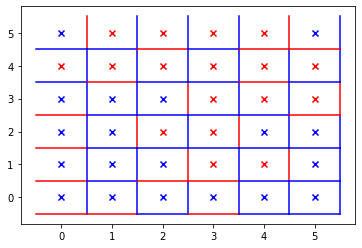

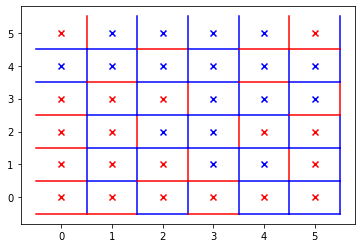

In [186]:
for i in range(-6, -1):
    plot_state(samples[0][i])

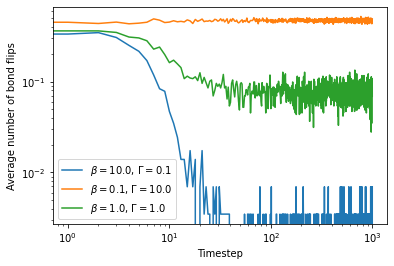

In [187]:
combos = [(0,-1), (-1, 0), (15, 15)]
for i,j in combos:
    samples = load_or_run_samples(hs[i], betas[j], timesteps=1000)
    samples, _ = zip(*samples)
    samples = numpy.asarray(samples).T
    samples = samples*2 - 1
    bond_mat = (make_bond_matrix(samples) + 1) /2

    diffs = numpy.mean(numpy.mean(numpy.abs(numpy.diff(bond_mat, axis=1)), axis=0), axis=-1)
    pyplot.plot(diffs, label=r"$\beta={:.1f}$, $\Gamma={:.1f}$".format(betas[j], hs[i]))

pyplot.xlabel('Timestep')
pyplot.ylabel('Average number of bond flips')
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.legend()
pyplot.show()

### Order parameter from 1207.1618

$d_{i,\alpha} = \frac{1}{2}\left(1 - \frac{J_{i,i+e_\alpha}}{J \sigma_i^z \sigma_{i+e_\alpha}^z}\right) = \frac{1}{2}\left(1 - S_{i,i+e_\alpha}\right)$

$\tilde{d_\alpha}(\vec{q}) = \frac{1}{N} \sum_i e^{i \vec{q}\cdot \vec{r}_{i,\alpha}} d_{i,\alpha}$

$\Psi = 2\left(\tilde{d_x} (0, \pi) + i \tilde{d_y}(\pi,0)\right) = \vert \Psi \vert e^{i \phi}$

$\Psi_4 = \vert \Psi \vert \mbox{cos}(4 \phi)$

In [188]:
def d_mat(bonds, dx=1, dy=0):
    edge_x = edge_list % side_len
    edge_y = edge_list // side_len
    
    axs, bxs = edge_x[:,0], edge_x[:,1]
    ays, bys = edge_y[:,0], edge_y[:,1]
    
    x_mask = (axs + dx) % side_len == bxs
    y_mask = (ays + dy) % side_len == bys
    mask = x_mask & y_mask
    
    # We use a different sign convention, + instead of -
    dm = (1 + bonds[mask])/2
    bond_indices = numpy.arange(len(mask))[mask]
    return bond_indices, dm


def make_order_param_for_samples(samples):
    samples = numpy.asarray(samples)
    all_bonds = make_bond_matrix(samples*2 - 1)  # In +1/-1 format
    dx_indices, dx_bonds = d_mat(all_bonds, dx=1, dy=0)
    dx_edges = edge_list[dx_indices]
    dy_indices, dy_bonds = d_mat(all_bonds, dx=0, dy=1)
    dy_edges = edge_list[dy_indices]
    
    # First do dx(0,pi)
    dx_edges_y_values = dx_edges[:,1] // side_len
    dy_edges_x_values = dy_edges[:,0] % side_len
    
    dx_mults = numpy.exp(1.0j * numpy.pi * dx_edges_y_values)
    dx_mults = numpy.expand_dims(numpy.expand_dims(dx_mults, -1),-1)
    
    dy_mults = numpy.exp(1.0j * numpy.pi * dy_edges_x_values)
    dy_mults = numpy.expand_dims(numpy.expand_dims(dy_mults, -1),-1)
    
    dx_sum = numpy.sum(dx_bonds * dx_mults, axis=0) / nvars
    dy_sum = numpy.sum(dy_bonds * dy_mults, axis=0) / nvars
    
    psi = 2*(dx_sum + 1.0j*dy_sum)
    return numpy.abs(psi) * numpy.cos(4*numpy.angle(psi))


def psi_order_param_samples(h, beta, timesteps=1000, start_index=0, end_index=-1):
    samples = load_or_run_samples(h, beta, timesteps=timesteps)
    samples, _ = zip(*samples)
    samples = numpy.asarray(samples)[:,start_index:end_index,:].T
    samples = samples * 2 - 1
    
    order_params = make_order_param_for_samples(samples)
    return numpy.mean(order_params)
psi_order_param_samples = numpy.vectorize(psi_order_param_samples)

In [189]:
order_params = psi_order_param_samples(HS, BETAS)

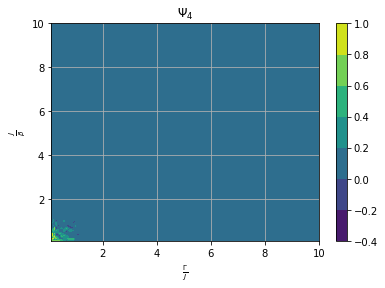

In [190]:
pyplot.contourf(HS, 1/BETAS, order_params)
pyplot.xlabel(r'$\frac{\Gamma}{J}$')
pyplot.ylabel(r'$\frac{J}{\beta}$')
pyplot.title(r'$\Psi_4$')
pyplot.colorbar()
pyplot.grid()
pyplot.show()

In [191]:
zoomed_hs = 10**numpy.linspace(-2,numpy.log10(2),20)
zoomed_betas = 10**numpy.linspace(numpy.log10(0.5),2,20)
ZOOMED_HS, ZOOMED_BETAS = numpy.meshgrid(zoomed_hs, zoomed_betas)

In [192]:
zoomed_order_params = psi_order_param_samples(ZOOMED_HS, ZOOMED_BETAS)

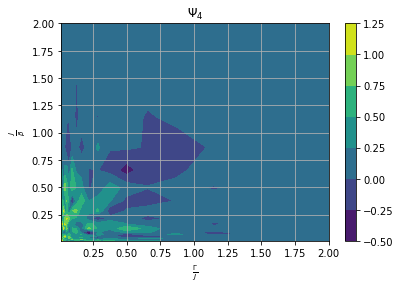

In [193]:
pyplot.contourf(ZOOMED_HS, 1/ZOOMED_BETAS, zoomed_order_params)
pyplot.xlabel(r'$\frac{\Gamma}{J}$')
pyplot.ylabel(r'$\frac{J}{\beta}$')
pyplot.title(r'$\Psi_4$')
pyplot.colorbar()
pyplot.grid()
pyplot.show()